### Setting up the environment and downloading the dataset

In [384]:
!pip install mlend==1.0.0.4
# 2. Import library and functions
import mlend
from mlend import download_deception_small, deception_small_load

# 3. Download small data
datadir = download_deception_small(save_to='MLEnd', subset={}, verbose=1, overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|100\100|00100.wav
Done!


#                      [LieSpy-Audio Deception Detection in Human Speech]

# 1 Author

**Student Name**: Prince Yadav

**Student ID**: 240685205  



# 2 Problem formulation
In this Machine learning problem Classification task is performed for deception detection on speech audio(.wav) files, we will classify the stories into binary labels either the story is **true** or **deceptive**, this will help to idenfity whether a person is speaking truth or lying, intersting thing about this is this can be further used to make a advance model which benefit various sectors such as legal field, fraud detection and healthcare by detecting the deceptive behaviour in real- world.


# 3 Methodology
Model take features as input and predcit whether the story is true or deceptive, Training task is performed to train the model the validate the model by testing it on unseen audio files.
Model performance is defined using the **classification table** which shows **accuracy**, **precision**, **recall** and **F1-score**, we will evaluate the model performance primarily using the **recall metric** for **deceptive story**, this focus on minimizing the **False Deceptive Stories** which ensure most deceptive stories are identified. Selection of metrices totally depends on application to application if False True Stories is costly then we  will focus on Precision of Deceptive Stories. F1 - score can be used if both False True and Deceptive are important. I would go with the recall of deceptive aim of this application is to detect the deception, so it should properly flag the true deceptive stories, again its totally depends on your application and the cost of False True and False Deceptive.

# 4 Implemented ML prediction pipelines



        Load the data of audio files and their csv file which contains their respective labels
                      V
        Split the data into Train, Validate Data          
                      V
        Divide the audio file into 30 second chunks (drop last chunk if its duration is less than 30 seconds)
                      V
        Extract features - Pitch Standard Deviation and ZCR(Zero Crossing Rate)
                      V
        Normalise the features using Min-Max Scaler
                      V
        Train K-Nearest Neighbors (KNN) on training data
                      V
        Validate the model on Validation dataset using metrices like Confusion matrix, accuracy, precision, recall, F1-score and ROC AUC


## 4.1 Transformation stage
Audio File $--> $ Split in train test (80-20 ratio)  $--> $  30 seconds chunks seperately for **train** and **test** data,drop the last chunk if it is less than 30 seconds  $--> $ **Pitch standard deviation** , **zero crossing rate** are extracted from the audio(.wav) files $--> $ Store extracted features in a dataframe sperately for Train and Test data.

There are many ways of chunking,for instance, you can  create chunks from the audio file each chunks of 30 seconds without overlapping (15seconds) and drop the last chunk if its duration is less than 30 seconds.
I have explored various combinations of features, including **Power**,**Pitch mean**, **MFCCs** with different dimensions (e.g., 13, 20, 40), **Spectral Centroid**, **Speech Rate**, **Pauses**, **Power**, **Short Term Energy**, **Spectral Flateness**.

**ZCR (Zero Crossing Rate)** measures the frequency of signal sign changes and is often used to detect noise or rapid transitions in audio.

**Pitch Std (Pitch Standard Deviation)** measures the variability of the pitch in an audio signal, helping to analyze emotional tone or speech patterns, useful in tasks like deception detection.

Compare their metrices on different models and decided to proceed with ZCR(Zero Crossing rate), Pitch Standard deviation.

*Compare different combination of features on different models with and without overlapping.*

#### Path of Downloaded audio(.wav) files and Labels CSV File

In [385]:
audio_main = '/content/MLEnd/deception/MLEndDD_stories_small/'
csv = '/content/MLEnd/deception/MLEndDD_story_attributes_small.csv'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


#### Path of Directory for train & test data and CSV




In [386]:
  # This Directory store the test and train dataset
train_test_directory = "/content/MLEnd/Train_Test_Split"

#### Splitting the audio files into Train Test before further processing


In [387]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Load the CSV file
csv_df = pd.read_csv(csv)

# Ensure the filenames match the actual .wav files
csv_df['filepath'] = csv_df['filename'].apply(lambda x: os.path.join(audio_main, x))

# Split the data train, test (80-20 ratio )
train_data, test_data = train_test_split(csv_df, test_size=0.2, random_state=42, stratify=csv_df['Story_type']) # startify helps to maintain the class balance

# Create directories for split data
train_dir = os.path.join(train_test_directory, 'train_audio')
test_dir = os.path.join(train_test_directory, 'test_audio')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to copy files to corresponding directories
def copy_files(data_subset, destination_dir):
    for _, row in data_subset.iterrows():
        destination_path = os.path.join(destination_dir, row['filename'])
        shutil.copy(row['filepath'], destination_path)

# Copy files to train and test directories
copy_files(train_data, train_dir)
copy_files(test_data, test_dir)

# Save CSVs for train and test splits
train_data.to_csv(os.path.join(train_test_directory, 'train_csv.csv'), index=False)
test_data.to_csv(os.path.join(train_test_directory, 'test_csv.csv'), index=False)

print("Data successfully split into train and test sets.")

Data successfully split into train and test sets.


#### Path of splitted original full length audio9(.wav) and CSV files

In [388]:
# paths of training and testing dataset(splitted data files and their csv is stored)
train_audio = '/content/MLEnd/Train_Test_Split/train_audio'
test_audio = '/content/MLEnd/Train_Test_Split/test_audio'
train_csv = '/content/MLEnd/Train_Test_Split/train_csv.csv'
test_csv = '/content/MLEnd/Train_Test_Split/test_csv.csv'

# Paths of chunk audio files ( where the chunks of train, test files will be stored)
main_chunk_folder = '/content/MLEnd/Chunks&CSV'
train_chunk_folder = os.path.join(main_chunk_folder, 'train_wav') # chunks of train datset stored here
test_chunk_folder = os.path.join(main_chunk_folder, 'test_wav') # chunks of test dataset stored here
os.makedirs(train_chunk_folder, exist_ok=True) # create a directory for chunks of train wav files
os.makedirs(test_chunk_folder, exist_ok=True) # create a directory for chunks of test wav files


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


#### Chunking Train and Test Seperately

In [389]:
import os, glob
import pandas as pd
import librosa
import soundfile as sf

def create_audio_chunks(df, source_audio_folder, dest_audio_folder, chunk_length=30):

    if not os.path.exists(dest_audio_folder):
        os.makedirs(dest_audio_folder)

    chunk_data = []
    for index, row in df.iterrows():
        file_path = os.path.join(source_audio_folder, row['filename'])
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        try:
            y, sr = librosa.load(file_path, sr=16000)
            total_samples = len(y)
            chunk_samples = chunk_length * sr  # Number of samples in a chunk

            num_chunks = total_samples // chunk_samples  # Number of full chunks

            for i in range(num_chunks):
                start = i * chunk_samples
                end = start + chunk_samples
                chunk = y[start:end]

                # Save the chunk
                chunk_filename = f"{row['filename'].split('.')[0]}_chunk_{i+1}.wav"
                chunk_filepath = os.path.join(dest_audio_folder, chunk_filename)
                sf.write(chunk_filepath, chunk, sr)

                # Add metadata for the chunk
                chunk_data.append({
                    'filename': chunk_filename,
                    'label': row['Story_type'],
                    'start_time': start / sr,
                    'end_time': end / sr
                })
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return pd.DataFrame(chunk_data)

# Load training and testing data
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Create and save chunks for training data
train_chunks_wav = create_audio_chunks(train_df, train_audio, train_chunk_folder, chunk_length=30)
train_chunks_csv = os.path.join(main_chunk_folder, 'train_chunks.csv')
train_chunks_wav.to_csv(train_chunks_csv, index=False)

# Create and save chunks for testing data
test_chunks_wav = create_audio_chunks(test_df, test_audio, test_chunk_folder, chunk_length=30)
test_chunks_csv = os.path.join(main_chunk_folder, 'test_chunks.csv')
test_chunks_wav.to_csv(test_chunks_csv, index=False)

print(f"Train and test chunks saved in '{main_chunk_folder}'")

Train and test chunks saved in '/content/MLEnd/Chunks&CSV'


#### Train and Test chunks files path and CSV loading

In [390]:
train_chunk_path = '/content/MLEnd/Chunks&CSV/train_wav/*.wav'
train_files = glob.glob(train_chunk_path)
print(f"No. of .wav chunks in train data: {len(train_files)}")
test_chunk_path = '/content/MLEnd/Chunks&CSV/test_wav/*.wav'
test_files = glob.glob(test_chunk_path)
print(f"No. of .wav chunks in test data: {len(test_files)}")

# Load the Train and Test Chunks CSV
train_chunks_df = pd.read_csv(train_chunks_csv).set_index('filename')
test_chunks_df = pd.read_csv(test_chunks_csv).set_index('filename')

No. of .wav chunks in train data: 336
No. of .wav chunks in test data: 84


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


#### Extract features - ZCR and Pitch standard deviation

In [391]:
import librosa
import numpy as np
from tqdm import tqdm
def getXy(files,labels_file):
  X,y =[],[]
  for file in tqdm(files):
    filename = file.split('/')[-1]
    yi = labels_file.loc[filename]['label']=='true_story'

    fs = 16000 # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    pitches, magnitudes = librosa.piptrack(y=x, sr=fs)
    pitch = pitches[magnitudes > np.percentile(magnitudes, 95)]  # Use high-magnitude pitches
    pitch_std = np.std(pitch) if len(pitch) > 0 else 0

    zcr = np.mean(librosa.feature.zero_crossing_rate(y=x))
    xi = [zcr,pitch_std]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

X_train, y_train = getXy(train_files,train_chunks_df)
X_test, y_test = getXy(test_files,test_chunks_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
100%|██████████| 84/84 [00:06<00:00, 12.69it/s]


#### Label Encoding

In [392]:
from sklearn.preprocessing import LabelEncoder
# True Story = 1
# Deceptive Story = 0
labels = LabelEncoder()
y_train = labels.fit_transform(y_train)
y_test = labels.transform(y_test)

#### Scaling features using MinMax Scaler

In [393]:
from re import X
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## 4.2 Model stage
**K-Nearest Neighbors (KNN)** is used because of its simplicity and intuition. It has the ability to handle non-linear decision boundaries, which is important in deception detection, where features like **pitch standard deviation** and **Zero Crossing Rate (ZCR)** may have complex and non-linear relationships. KNN can handle these complexities effectively. Additionally, KNN works well for small datasets. As a model based on distance metrics, it is both simple and efficient.

I have also tried **SVC (Support Vector Classifier)** and **Random Forest Classifier**. These two models are more complex than KNN, but in this specific problem, KNN outperformed both of them.
I have tested these two models with different combination of hyperparameters.

Cross-validation is generally a great technique for evaluating the performance of a model, but it can introduce issues when dealing with chunked data, especially in scenarios where the data is sequential or consists of multiple chunks from the same file. Here's why cross-validation may not be the best choice when working with chunked data.

#### KNN

In [394]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn = knn.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## 4.3 Ensemble stage

 Tried hard voting ensemble technique on knn and random forest classifier, and compare with both models.
 Didn't see any change in metrices.


# 5 Dataset
Two separate datasets, **Train and Test**, were created before chunking to prevent data leakage. If chunking is done first and then the data is split, there is a risk that chunks from the same file could end up in both the training and validation datasets. This would lead to better performance on the validation set but poor generalization on unseen data.

A total of 100 audio files were available, which were split into 80% for training and 20% for testing before chunking. After chunking, the training set consists of 336 files, while the test set contains 84 files.





#### 5.1 Train Dataset

In [395]:
train_features_df = pd.DataFrame(X_train, columns=['zcr', 'pitch_std'])
train_features_df['filename'] = [file.split('/')[-1] for file in train_files]
train_features_df['label'] = y_train
train_features_df.set_index('filename', inplace=True)
print(train_features_df.head())

                        zcr  pitch_std  label
filename                                     
00005_chunk_3.wav  0.460200   0.696999      0
00053_chunk_3.wav  0.271450   0.835365      0
00038_chunk_3.wav  0.676955   0.695293      0
00075_chunk_2.wav  0.457857   0.852173      1
00045_chunk_1.wav  0.675679   0.850625      0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Shape of Train Data

In [396]:
print(train_features_df.shape)

(336, 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Class count

1 - True

0 - Deceptive

In [397]:
train_features_df['label'].value_counts()

,count
label,
1,174
0,162


Plotting PDF of ZCR and Pitch Standard Deviation for Train  Data

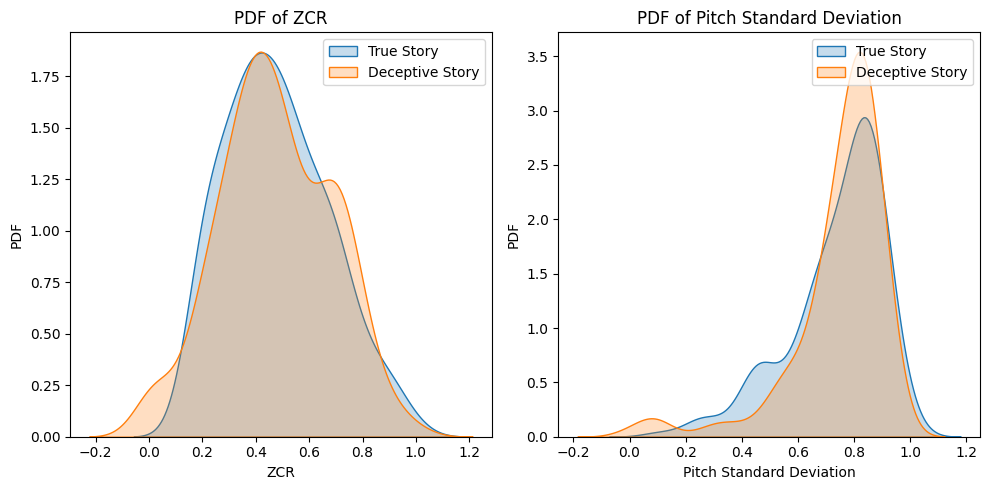

In [398]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(train_features_df[train_features_df['label'] == 1]['zcr'], label='True Story', fill=True)
sns.kdeplot(train_features_df[train_features_df['label'] == 0]['zcr'], label='Deceptive Story', fill=True)
plt.xlabel('ZCR')
plt.ylabel('PDF')
plt.title('PDF of ZCR')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(train_features_df[train_features_df['label'] == 1]['pitch_std'], label='True Story', fill=True)
sns.kdeplot(train_features_df[train_features_df['label'] == 0]['pitch_std'], label='Deceptive Story', fill=True)
plt.xlabel('Pitch Standard Deviation')
plt.ylabel('PDF')
plt.title('PDF of Pitch Standard Deviation')
plt.legend()

plt.tight_layout()
plt.show()

#### Scatter plot for Train Data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


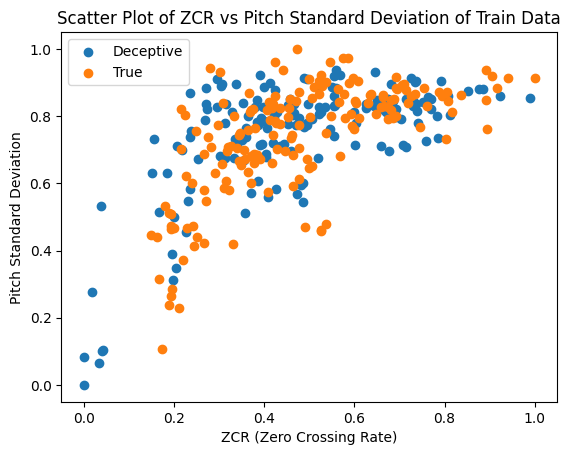

In [399]:
from numpy import where
from collections import Counter
from sklearn.datasets import make_blobs
from matplotlib import pyplot

counter = Counter(y_train)

for label, _ in counter.items():
  label_name = 'True' if label == 1 else 'Deceptive'
  row_ix = where(y_train == label)
  pyplot.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=label_name)
pyplot.legend()
pyplot.xlabel('ZCR (Zero Crossing Rate)')
pyplot.ylabel('Pitch Standard Deviation')
pyplot.title('Scatter Plot of ZCR vs Pitch Standard Deviation of Train Data')
pyplot.show()

#### 5.2 Test Dataset

In [400]:
test_features_df = pd.DataFrame(X_test, columns=['zcr', 'pitch_std'])
test_features_df['filename'] = [file.split('/')[-1] for file in test_files]
test_features_df['label'] = y_test
test_features_df.set_index('filename', inplace=True)
test_features_df.head()

,zcr,pitch_std,label
filename,,,
00089_chunk_4.wav,0.553656,0.749307,0
00061_chunk_1.wav,0.298284,0.703685,1
00028_chunk_4.wav,0.454588,0.807021,1
00043_chunk_5.wav,0.194241,0.447463,1
00018_chunk_4.wav,0.695460,0.819059,1


Shape of test data

In [401]:
print(test_features_df.shape)

(84, 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Class count

1 - True

0 - Deceptive

In [402]:
test_features_df['label'].value_counts()

,count
label,
1,45
0,39


Plotting PDF of ZCR and Pitch Standard deviation for Test Data

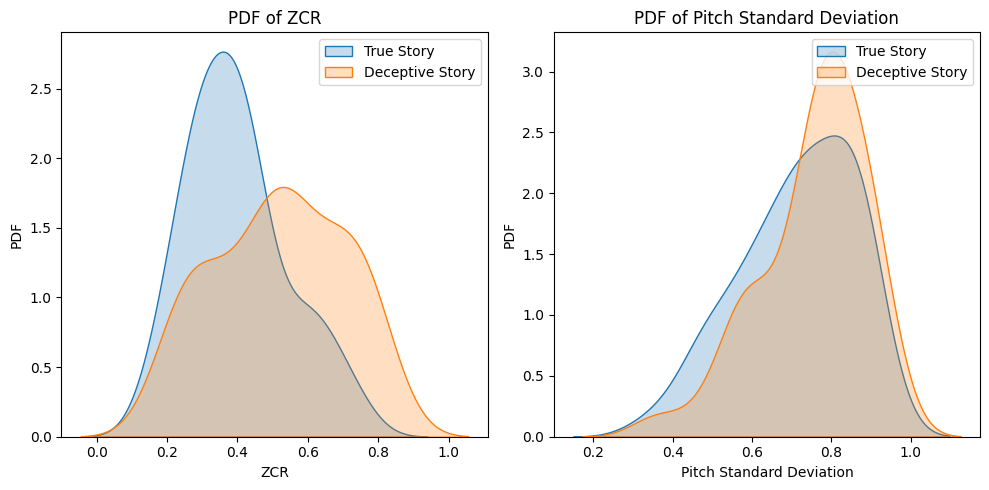

In [403]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(test_features_df[test_features_df['label'] == 1]['zcr'], label='True Story', fill=True)
sns.kdeplot(test_features_df[test_features_df['label'] == 0]['zcr'], label='Deceptive Story', fill=True)
plt.xlabel('ZCR')
plt.ylabel('PDF')
plt.title('PDF of ZCR')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(test_features_df[test_features_df['label'] == 1]['pitch_std'], label='True Story', fill=True)
sns.kdeplot(test_features_df[test_features_df['label'] == 0]['pitch_std'], label='Deceptive Story', fill=True)
plt.xlabel('Pitch Standard Deviation')
plt.ylabel('PDF')
plt.title('PDF of Pitch Standard Deviation')
plt.legend()

plt.tight_layout()
plt.show()

#### Scatter Plot of Test Data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


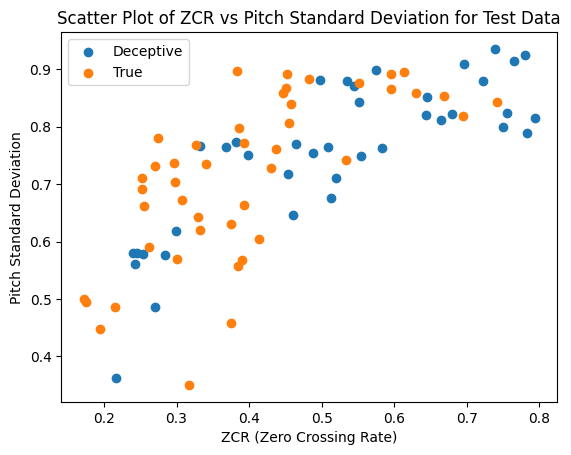

In [404]:
import numpy as np
from collections import Counter
from matplotlib import pyplot

counter = Counter(y_test)

for label, _ in counter.items():
  label_name = 'True' if label == 1 else 'Deceptive'
  row_ix = np.where(y_test == label)
  pyplot.scatter(X_test[row_ix,0], X_test[row_ix, 1], label=label_name)
pyplot.legend()
pyplot.xlabel('ZCR (Zero Crossing Rate)')
pyplot.ylabel('Pitch Standard Deviation')
pyplot.title('Scatter Plot of ZCR vs Pitch Standard Deviation for Test Data')
pyplot.show()

# 6 Experiments and results
**Class 0 - Deceptive**
**Precision:** 0.53 — 53% of the instances predicted as Deceptive (0) are correctly identified.

**Recall:** 0.79 — 79% of the actual Deceptive stories are correctly identified by the model.

**F1-Score:** 0.63 — A reasonable balance between precision and recall for Deceptive stories.


**Class 1 - True**
**Precision:** 0.68 — 68% of the instances predicted as True (1) are correctly identified.

**Recall:** 0.38 — Only 38% of the actual True stories are correctly classified, indicating that many True stories are missed.

**F1-Score:** 0.49 — A lower F1-score for True stories indicates that the model struggles more with detecting True stories.

**Overall Accuracy: 0.57**



#### KNN

#### Train Data Results


In [405]:
from sklearn.metrics import classification_report, confusion_matrix
train_classification_report = classification_report(y_train, knn.predict(X_train))
print("Train Classification Report of KNN:\n", train_classification_report)

# Confusion Matrix
cm = confusion_matrix(y_train, knn.predict(X_train))
print("Confusion Matrix of KNN:\n", cm)

Train Classification Report of KNN:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83       162
           1       1.00      0.61      0.76       174

    accuracy                           0.80       336
   macro avg       0.85      0.80      0.79       336
weighted avg       0.86      0.80      0.79       336

Confusion Matrix of KNN:
 [[162   0]
 [ 68 106]]


#### Test Data Results

In [406]:
test_classification_report = classification_report(y_test, knn.predict(X_test))
print("Test Classification Report of KNN:\n", test_classification_report)
cm = confusion_matrix(y_test, knn.predict(X_test))
print("Confusion Matrix of KNN:\n", cm)

Test Classification Report of KNN:
               precision    recall  f1-score   support

           0       0.53      0.79      0.63        39
           1       0.68      0.38      0.49        45

    accuracy                           0.57        84
   macro avg       0.60      0.59      0.56        84
weighted avg       0.61      0.57      0.55        84

Confusion Matrix of KNN:
 [[31  8]
 [28 17]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Confusion Matrix
True Positives (TP): 31

True Negatives (TN): 17

False Positives (FP): 8

False Negatives (FN): 28

In [407]:
from sklearn.metrics import roc_auc_score
y_pred_probability = knn.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_probability )
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.6008547008547009


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


ROC AUC score of 0.60 indicates that the model's performance is moderate and slightly better than random guessing.
Exploring additional techniques like feature engineering, model selection potentially imporove overall model performance.

# 7 Conclusions
Real world datasets are typically more complex, which means even well-balanced datasets can present difficulties for models to generalize effectively.
KNN ,Random Forests, SVM may not be the best model for this task, particularly with complex real-world data.

Neural Networks can be considered which can handle non-linear relationships and complex data patterns better than above used models.

Advance features extraction and advance feature engineering can help to improve model performance.
Your conclusions, suggestions for improvements, etc should go here.

# 8 References
Used these library for testing different hyperparamters
##### RandomForestClassifier
https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

##### Support Vector Classifier

https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html


##### ZCR Features
https://www.sciencedirect.com/science/article/pii/S0003682X19308795?fr=RR-2&ref=pdf_download&rr=8edcd9c0eab8952d

##### Google colab code generates is used for generating code for chunking part